In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

#from wordcloud import WordCloud
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

# Reset individual options to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

# Set desired options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

## Sentiment analysis is a powerful technique that involves determining the emotional tone of a piece of text.

**1. It classifies text as positive, negative, or neutral, and can even delve deeper into specific emotions like happiness, sadness, or anger. This process, often referred to as opinion mining, is a cornerstone of Natural Language Processing (NLP).**   

**2. By applying sentiment analysis, businesses can gain valuable insights into customer perceptions, product performance, and market trends. For instance, analyzing customer reviews can reveal whether a product is meeting customer expectations or if there's a need for improvement. Similarly, monitoring social media sentiment can help companies understand their brand reputation and identify potential issues.**   

**3. Sentiment analysis is particularly useful for processing large volumes of unstructured text data, such as customer feedback, social media posts, and survey responses. It efficiently categorizes this data, making it easier to extract meaningful information. Tools like Net Promoter Score (NPS) surveys, which measure customer loyalty, benefit greatly from sentiment analysis. By automating the analysis of NPS responses, businesses can quickly identify patterns and trends in customer sentiment.**   

**4. In essence, sentiment analysis empowers organizations to understand the voice of their customers, make data-driven decisions, and ultimately improve their products and services.**   

## Sentiment Analysis: Preprocessing Steps

**1. Data Collection:**

- Gather text data from various sources (e.g., customer reviews, social media posts, news articles)
- Ensure a diverse and representative sample for accurate analysis


**2. Text Cleaning:**

- Remove HTML tags, if present
- Strip special characters and punctuation that don't contribute to sentiment.
- Convert all text to lowercase for consistency.


**3. Tokenization:**

- Break down the text into individual words or tokens
- This step allows for analysis at the word level


**4. Stop Word Removal:**

- Identify and remove common words (e.g., "the", "is", "and") that don't carry sentiment
- This reduces noise in the data and focuses on meaningful words


**5. Stemming or Lemmatization:**

- Stemming: Reduce words to their root form by removing suffixes (e.g., "running" to "run")
- Lemmatization: Convert words to their base or dictionary form (e.g., "better" to "good")
- This step helps in standardizing words and reducing vocabulary size


**6. Handling Negations:**

- Identify negation words (e.g., "not", "never") and mark the affected phrases
- This is crucial as negations can invert the sentiment of surrounding words


**7. Dealing with Sarcasm and Context:**

- While challenging, attempt to identify sarcastic phrases or contextual nuances
- This may involve looking at surrounding sentences or overall tone


**8. Feature Extraction:**

- Convert the preprocessed text into a format suitable for machine learning algorithms
- Common methods include bag-of-words, TF-IDF, or word embeddings

**9. Normalization:**

- Standardize the features to ensure all inputs are on a similar scale
- This helps in improving the performance of many machine learning algorithms



In [2]:
train = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.csv',header=None)
validation = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/validation.csv',header=None)

train.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
validation.columns=['Tweet ID','Entity','Sentiment','Tweet Content']

print("Training DataSet: \n")
train = train.sample(10000)
display(train.head())

Training DataSet: 



Tweet ID                             Entity   Sentiment  \
18485      9967                  PlayStation5(PS5)  Irrelevant   
73746      9034                             Nvidia     Neutral   
6600        336                             Amazon    Negative   
18166      9914                  PlayStation5(PS5)    Positive   
43953     10347  PlayerUnknownsBattlegrounds(PUBG)    Negative   

                                                                                                              Tweet Content  
18485                                                                                                                    is  
73746  Nvidia on global foundries confirmed. TSMC is incapable to make enough big die for nvidia pic.twitter.com/KXTIPTNyl9  
6600                                                                                      Amazon doesn't deliver in my hood  
18166                                                                                    BOOOYYYYYY And I AD CANT A WAIT!!!  
43953                                                                                         PUBG is banned in this county

In [3]:
print("Validation DataSet: \n")
display(validation.head())

Validation DataSet: 



Tweet ID     Entity   Sentiment  \
0      3364   Facebook  Irrelevant   
1       352     Amazon     Neutral   
2      8312  Microsoft    Negative   
3      4371      CS-GO    Negative   
4      4433     Google     Neutral   

                                                                                                                                                                                             Tweet Content  
0  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma...  
1                                                                                            BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…  
2                                                                                                              @Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄  
3                                                                                                                                  CSGO matchmaking is so full of closet hacking, it's a truly awful game.  
4                               Now the President is slapping Americans in the face that he really did commit an unlawful act after his  acquittal! From Discover on Google vanityfair.com/news/2020/02/t…

In [4]:
train = train.dropna(subset=['Tweet Content'])

display(train.isnull().sum())
print("*****"* 5)
display(validation.isnull().sum())

Tweet ID         0
Entity           0
Sentiment        0
Tweet Content    0
dtype: int64

*************************


Tweet ID         0
Entity           0
Sentiment        0
Tweet Content    0
dtype: int64

In [5]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [6]:
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Combine counts into a single DataFrame
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis=1)

# Fill missing values (if any) with 0
combined_counts.fillna(0, inplace=True)

# Rename columns
combined_counts.columns = ['Test Data', 'Validation Data']  # Set desired column names

combined_counts

Test Data  Validation Data
Sentiment                             
Negative         3069              266
Positive         2709              277
Neutral          2396              285
Irrelevant       1673              172

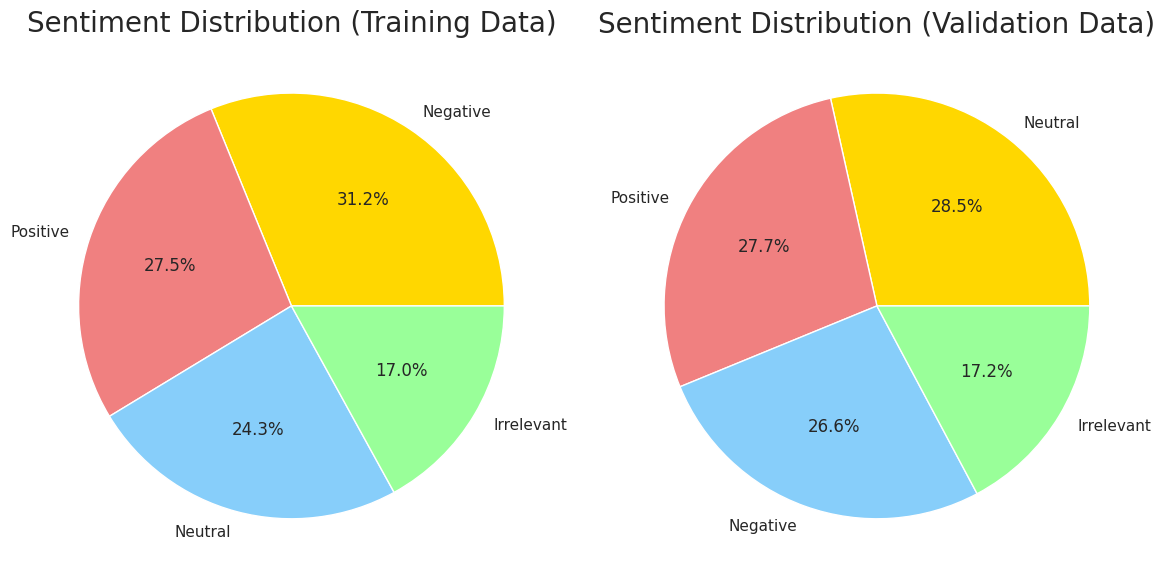

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize for better view

# Create pie chart for training data
ax1.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=20)

# Create pie chart for validation data
ax2.pie(sentiment_counts_validation, labels=sentiment_counts_validation.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [8]:
# Calculate the value counts of 'Entity'
entity_counts = train['Entity'].value_counts()

# Get the top 9 names
top_names = entity_counts.head(19)

# Aggregate the tenth name as 'Other'
other_count = entity_counts[19:].sum()
top_names['Other'] = other_count

# Display the top 19 names and 'Other'
top_names.to_frame()

count
Entity                          
Facebook                     339
Nvidia                       335
Microsoft                    335
Verizon                      329
Battlefield                  328
Dota2                        327
johnson&johnson              327
CallOfDutyBlackopsColdWar    325
CallOfDuty                   324
MaddenNFL                    324
AssassinsCreed               322
TomClancysRainbowSix         321
Fortnite                     319
Google                       318
NBA2K                        307
PlayStation5(PS5)            306
Cyberpunk2077                305
LeagueOfLegends              305
WorldOfCraft                 302
Other                       3749

In [9]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Calculate the percentages
percentages = (top_names / top_names.sum()) * 100

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=percentages.index,
    values=percentages,
    textinfo='label+percent',
    insidetextorientation='radial'
)])

# Update layout
fig.update_layout(
    title_text='Top Names with Percentages',
    showlegend=False
)

# Show the plot
fig.show()

## WordCloud

**WordCloud is a visualization technique used in machine learning (ML), especially in Natural Language Processing (NLP) tasks. It helps visualize textual data by displaying words in a cloud formation, where the size of each word reflects its frequency or importance in the text.**

- Data Input: You feed the WordCloud function with text data. This could be anything from a document collection, social media comments, or even code repositories.
- Frequency Analysis: The algorithm analyzes the text and counts the occurrences of each word.
- Word Placement and Sizing: Based on the frequency count, WordCloud positions and sizes the words. More frequent words appear larger and more prominent in the cloud, while less frequent ones are smaller.
- Visualization: Finally, it generates a visual output where the word cloud showcases the prominent themes and keywords within the text data.

**Benefits of using WordCloud in ML:**

- Easy Identification of Key Terms: Word clouds quickly reveal the most frequently used words, helping you understand the core focus of the text data.
- Text Summarization: They provide a summarized view of a large corpus of text, making it easier to grasp the overall content.
- Highlighting Trends: Word clouds can be used to identify emerging trends or topics of discussion within the text data.

**Applications of WordCloud in ML:**

- Analyzing social media sentiment: See which words are most commonly used when people express positive or negative opinions.
- Topic modeling for research papers: Identify the main themes discussed in a collection of research papers.
- Understanding user reviews: Analyze product reviews to see which features are most mentioned by users.

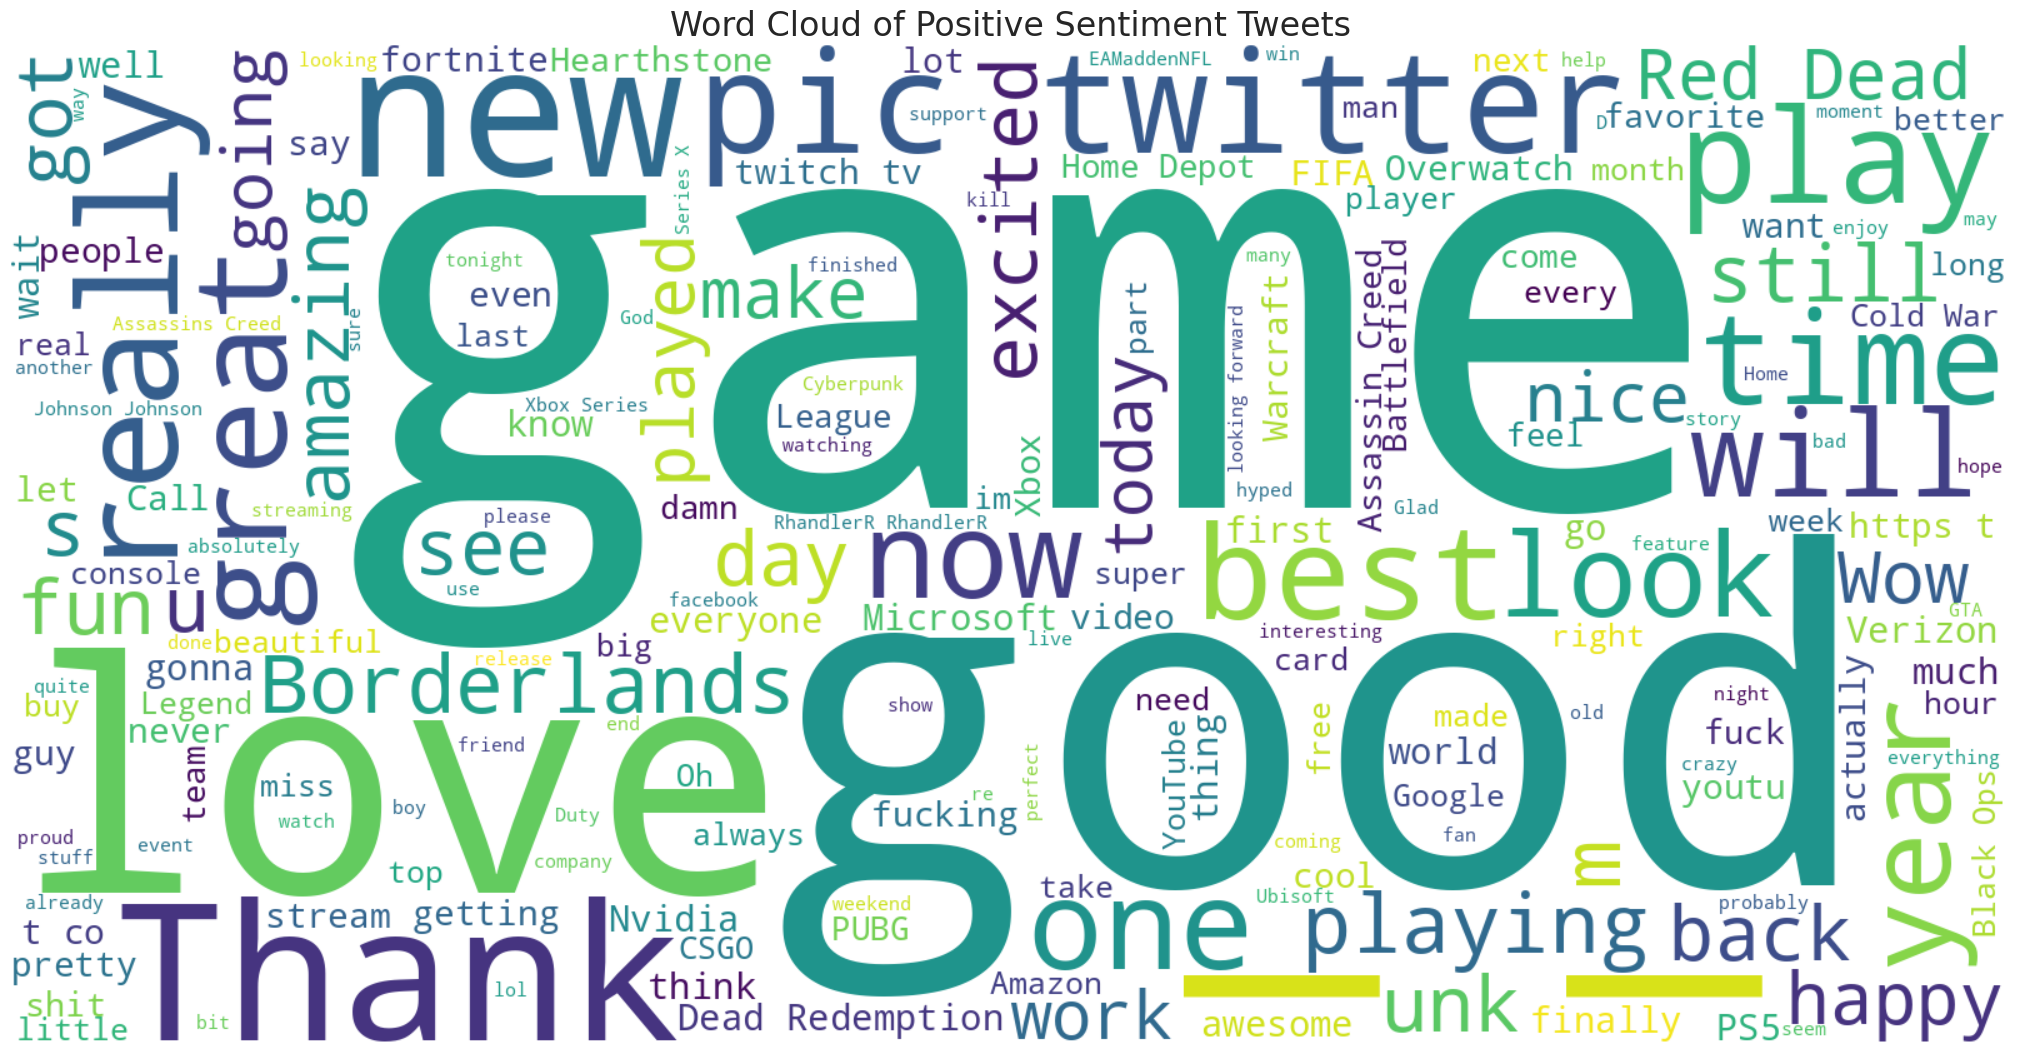

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter positive sentiment tweets and extract the 'Tweet Content' column
positive_tweets = train[train["Sentiment"] == "Positive"]["Tweet Content"]

# Join all the positive tweets into a single string
positive_text = ' '.join(positive_tweets)

# Create a WordCloud object with increased size and more words
wordcloud = WordCloud(width=1600, height=800, max_words=200, background_color='white').generate(positive_text)

# Display the word cloud with a larger figure size
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Sentiment Tweets', fontsize=24)
plt.tight_layout(pad=0)
plt.show()

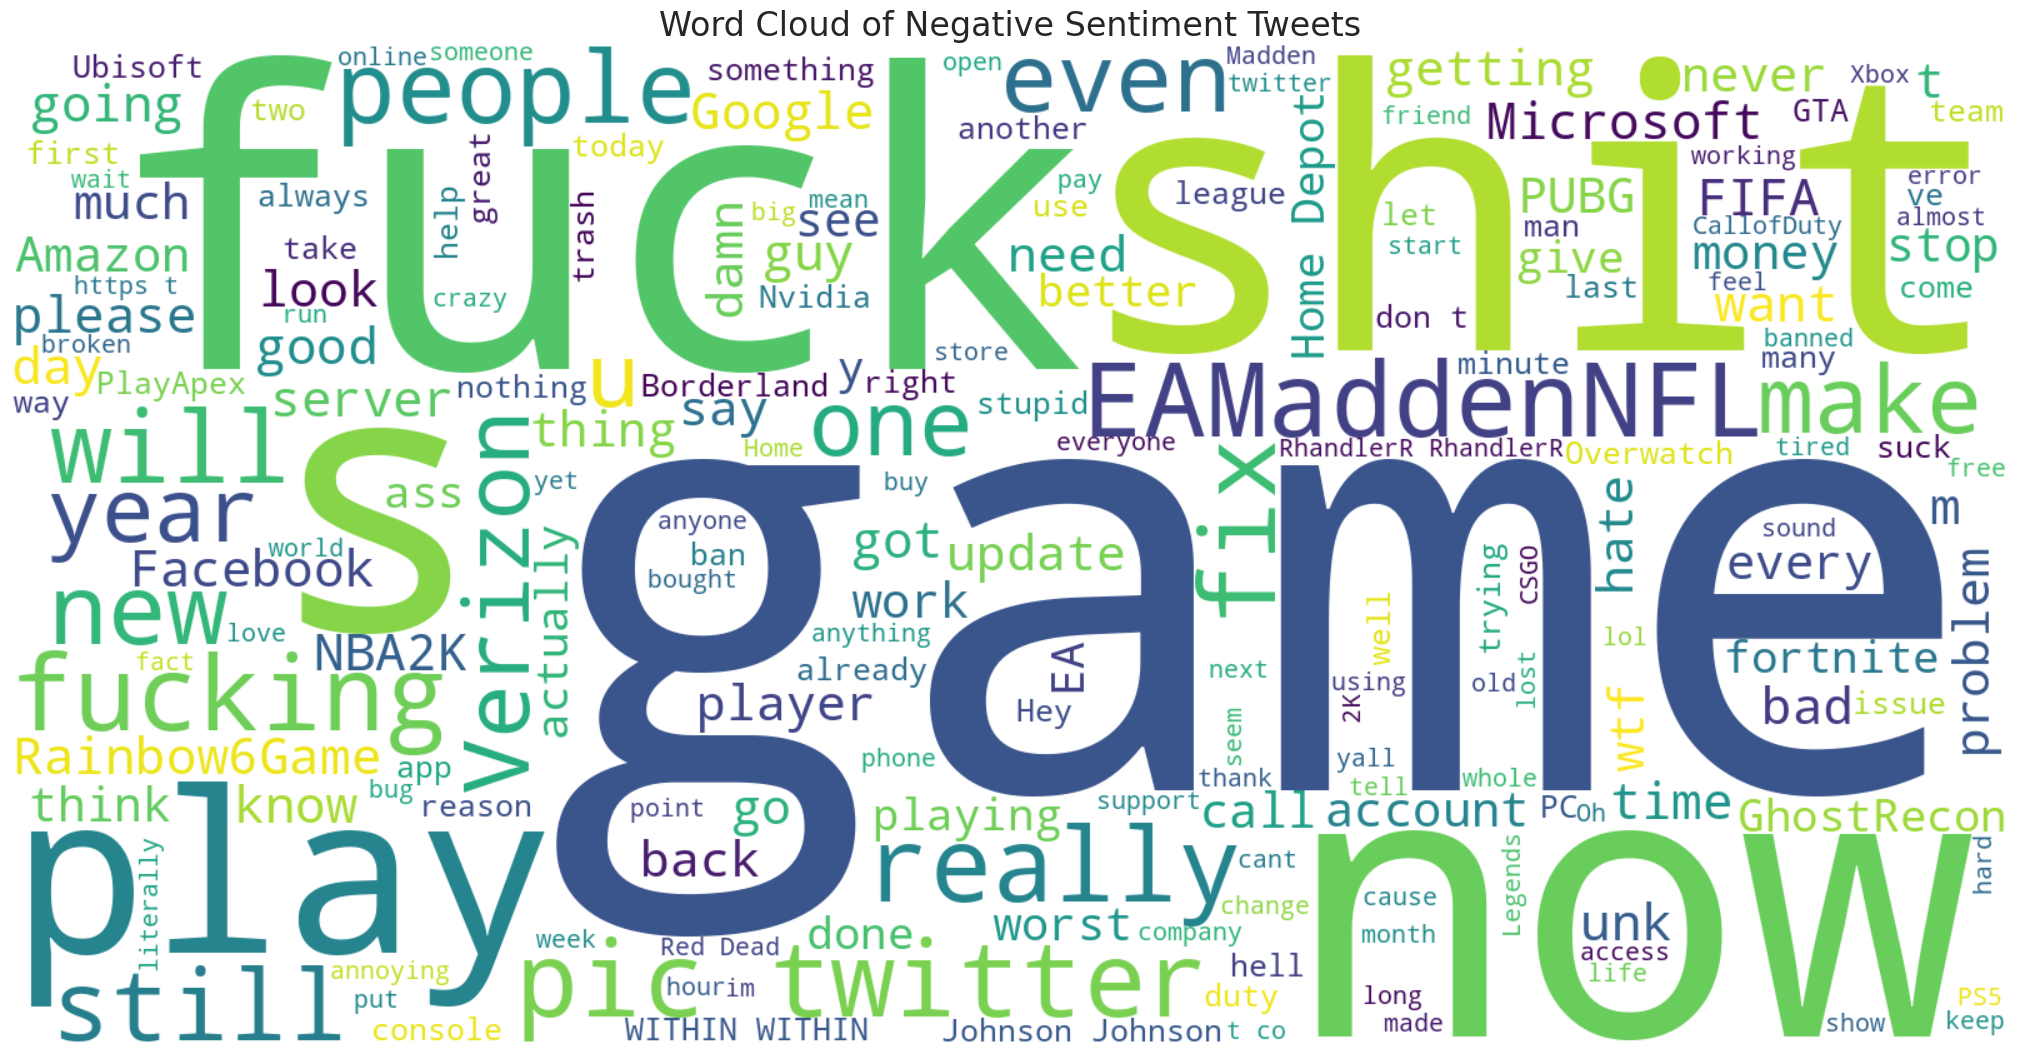

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter positive sentiment tweets and extract the 'Tweet Content' column
negative_tweets = train[train["Sentiment"] == "Negative"]["Tweet Content"]

# Join all the positive tweets into a single string
negative_text = ' '.join(negative_tweets)

# Create a WordCloud object with increased size and more words
wordcloud = WordCloud(width=1600, height=800, max_words=200, background_color='white').generate(negative_text)

# Display the word cloud with a larger figure size
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Sentiment Tweets', fontsize=24)
plt.tight_layout(pad=0)
plt.show()

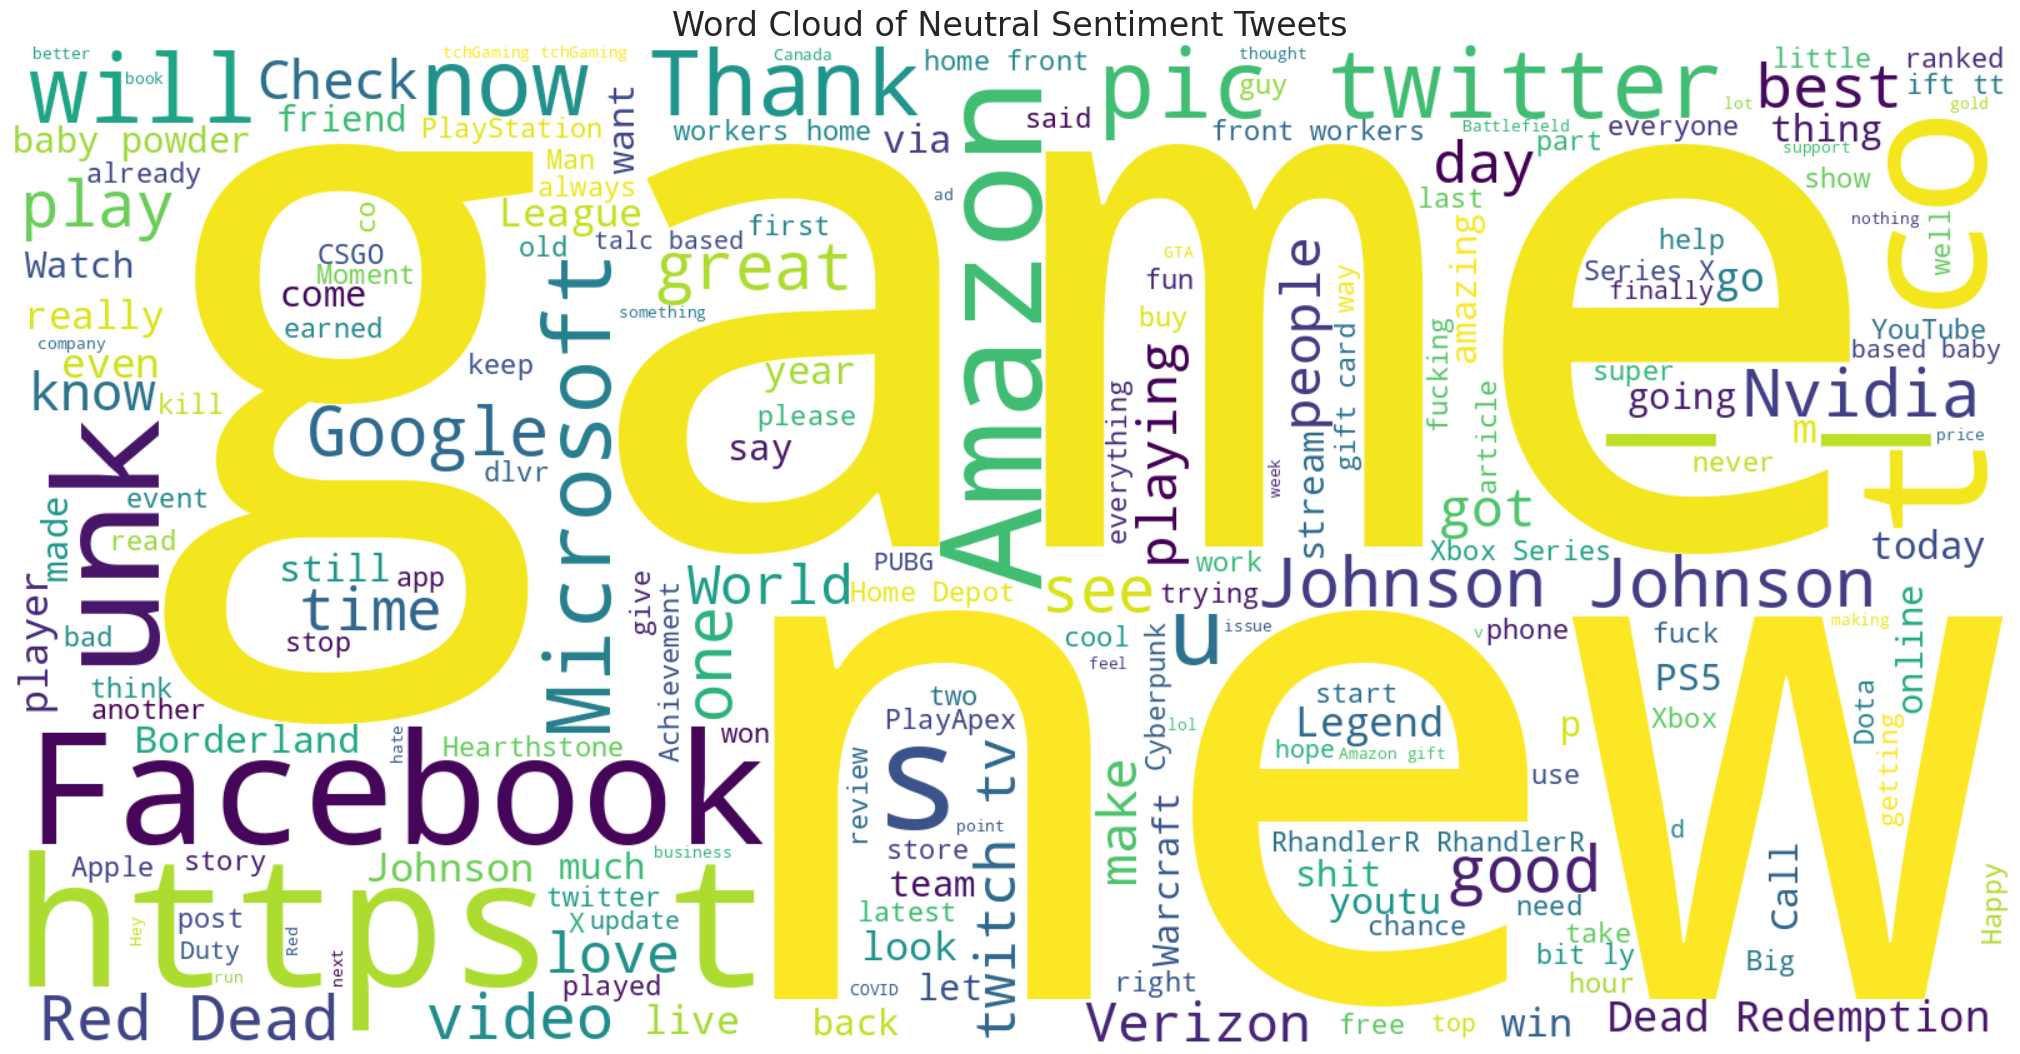

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter Neutral sentiment tweets and extract the 'Tweet Content' column
neutral_tweets = train[train["Sentiment"] == "Neutral"]["Tweet Content"]

# Join all the positive tweets into a single string
neutral_text = ' '.join(neutral_tweets)

# Create a WordCloud object with increased size and more words
wordcloud = WordCloud(width=1600, height=800, max_words=200, background_color='white').generate(neutral_text)

# Display the word cloud with a larger figure size
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Sentiment Tweets', fontsize=24)
plt.tight_layout(pad=0)
plt.show()

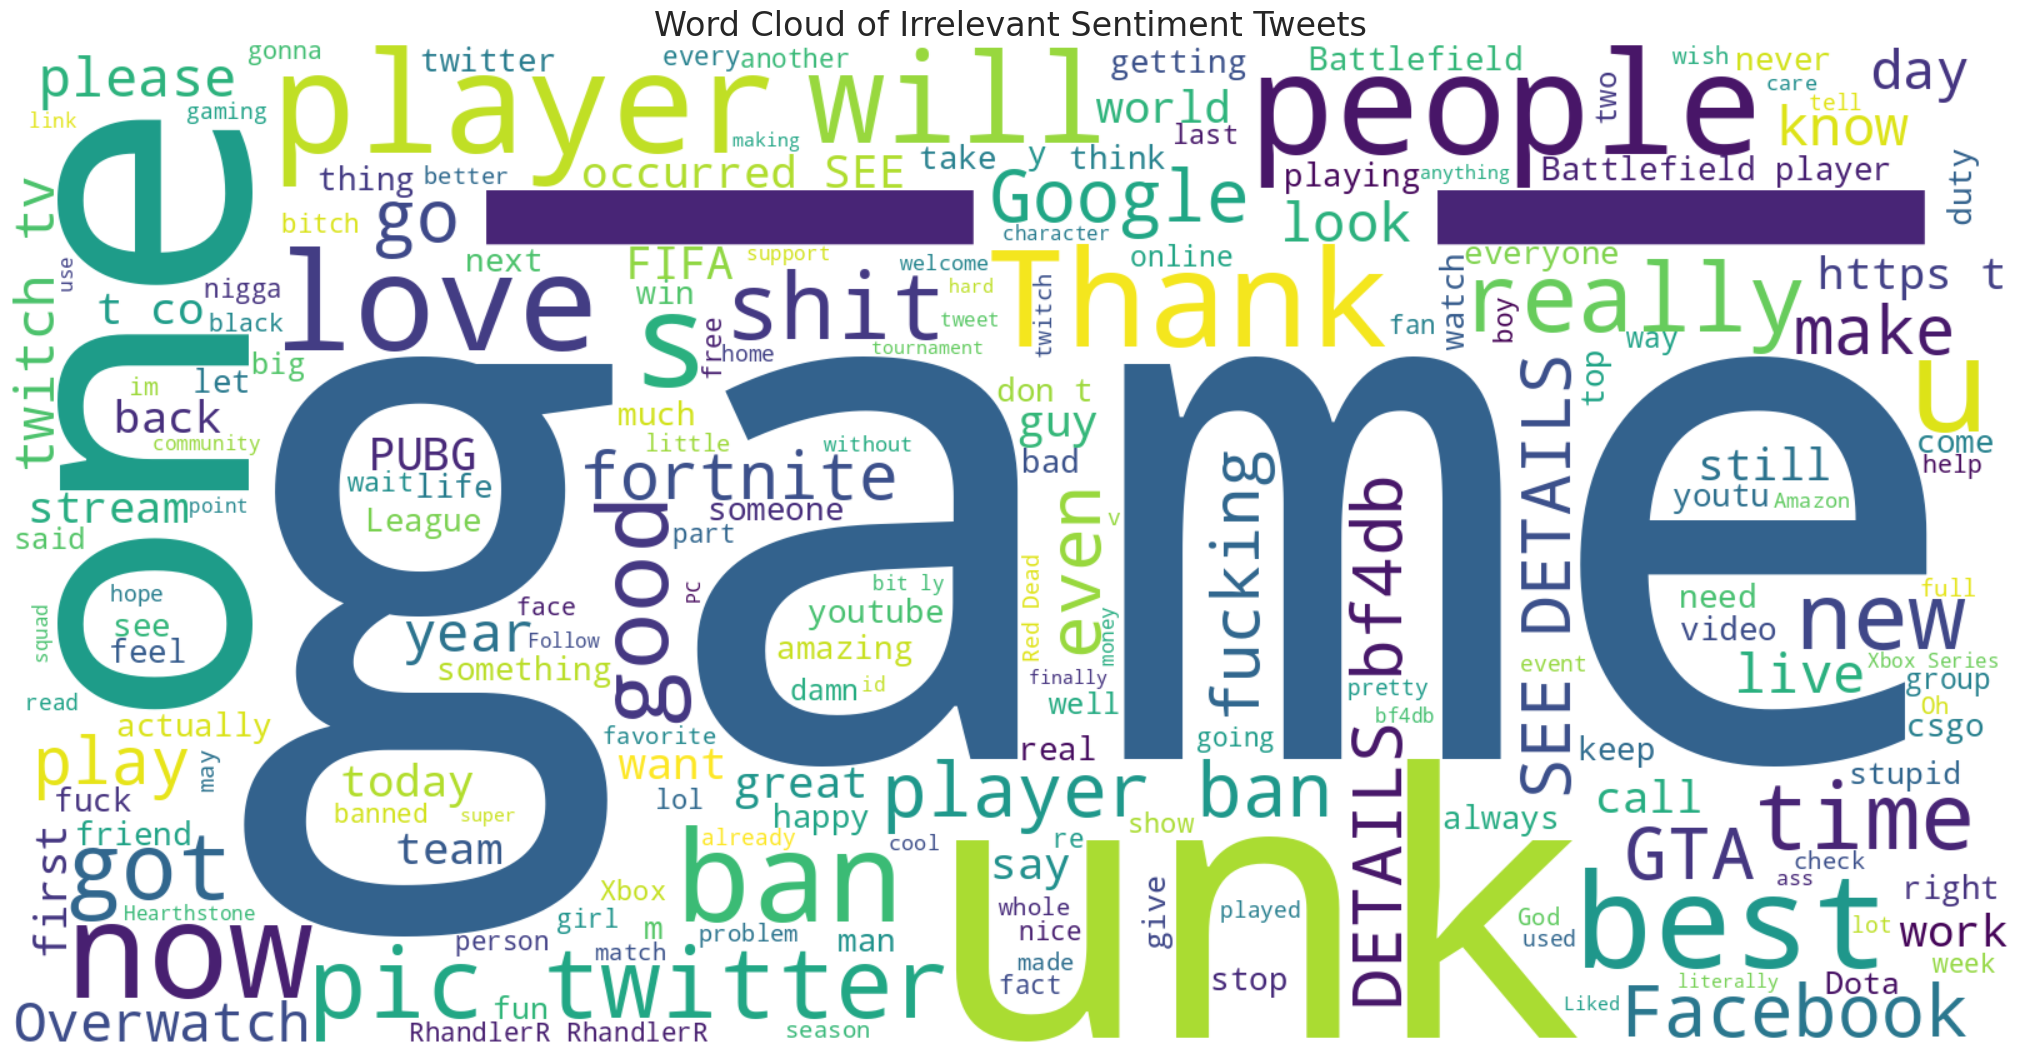

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter Neutral sentiment tweets and extract the 'Tweet Content' column
Irrelevant_tweets = train[train["Sentiment"] == "Irrelevant"]["Tweet Content"]

# Join all the positive tweets into a single string
Irrelevant_text = ' '.join(Irrelevant_tweets)

# Create a WordCloud object with increased size and more words
wordcloud = WordCloud(width=1600, height=800, max_words=200, background_color='white').generate(Irrelevant_text)

# Display the word cloud with a larger figure size
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Irrelevant Sentiment Tweets', fontsize=24)
plt.tight_layout(pad=0)
plt.show()

In [14]:
import pandas as pd
import plotly.graph_objects as go

# Assuming 'validation' is your DataFrame with 'Entity' and 'Sentiment' columns

# Group by 'Entity' and 'Sentiment' and calculate the count
grouped_counts = train.groupby(['Entity', 'Sentiment']).size().reset_index(name='Count')

# Calculate the total count for each entity
entity_total_counts = grouped_counts.groupby('Entity')['Count'].transform('sum')

# Calculate the percentage for each group
grouped_counts['Percentage'] = (grouped_counts['Count'] / entity_total_counts) * 100

# Sort the grouped counts by count in descending order
grouped_counts = grouped_counts.sort_values('Count', ascending=False)

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(grouped_counts.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[grouped_counts[k].tolist() for k in grouped_counts.columns],
        fill_color=[
            'lightcyan',
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative' else 'lightyellow' for s in grouped_counts['Sentiment']],
            'lavender',
            'lightsalmon'
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Entity and Sentiment Distribution',
    width=800,
    height=800,
)

# Show the figure
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Assuming 'validation' is your DataFrame with 'Entity' and 'Sentiment' columns

# Group by 'Entity' and 'Sentiment' and calculate the count
grouped_counts = validation.groupby(['Entity', 'Sentiment']).size().reset_index(name='Count')

# Calculate the total count for each entity
entity_total_counts = grouped_counts.groupby('Entity')['Count'].transform('sum')

# Calculate the percentage for each group
grouped_counts['Percentage'] = (grouped_counts['Count'] / entity_total_counts) * 100

# Sort the grouped counts by count in descending order
grouped_counts = grouped_counts.sort_values('Count', ascending=False)

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(grouped_counts.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[grouped_counts[k].tolist() for k in grouped_counts.columns],
        
        fill_color=[
            'lightcyan',
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative' else 'lightyellow' for s in grouped_counts['Sentiment']],
            'lavender',
            'lightsalmon'
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Entity and Sentiment Distribution',
    width=800,
    height=800,
)

# Show the figure
fig.show()

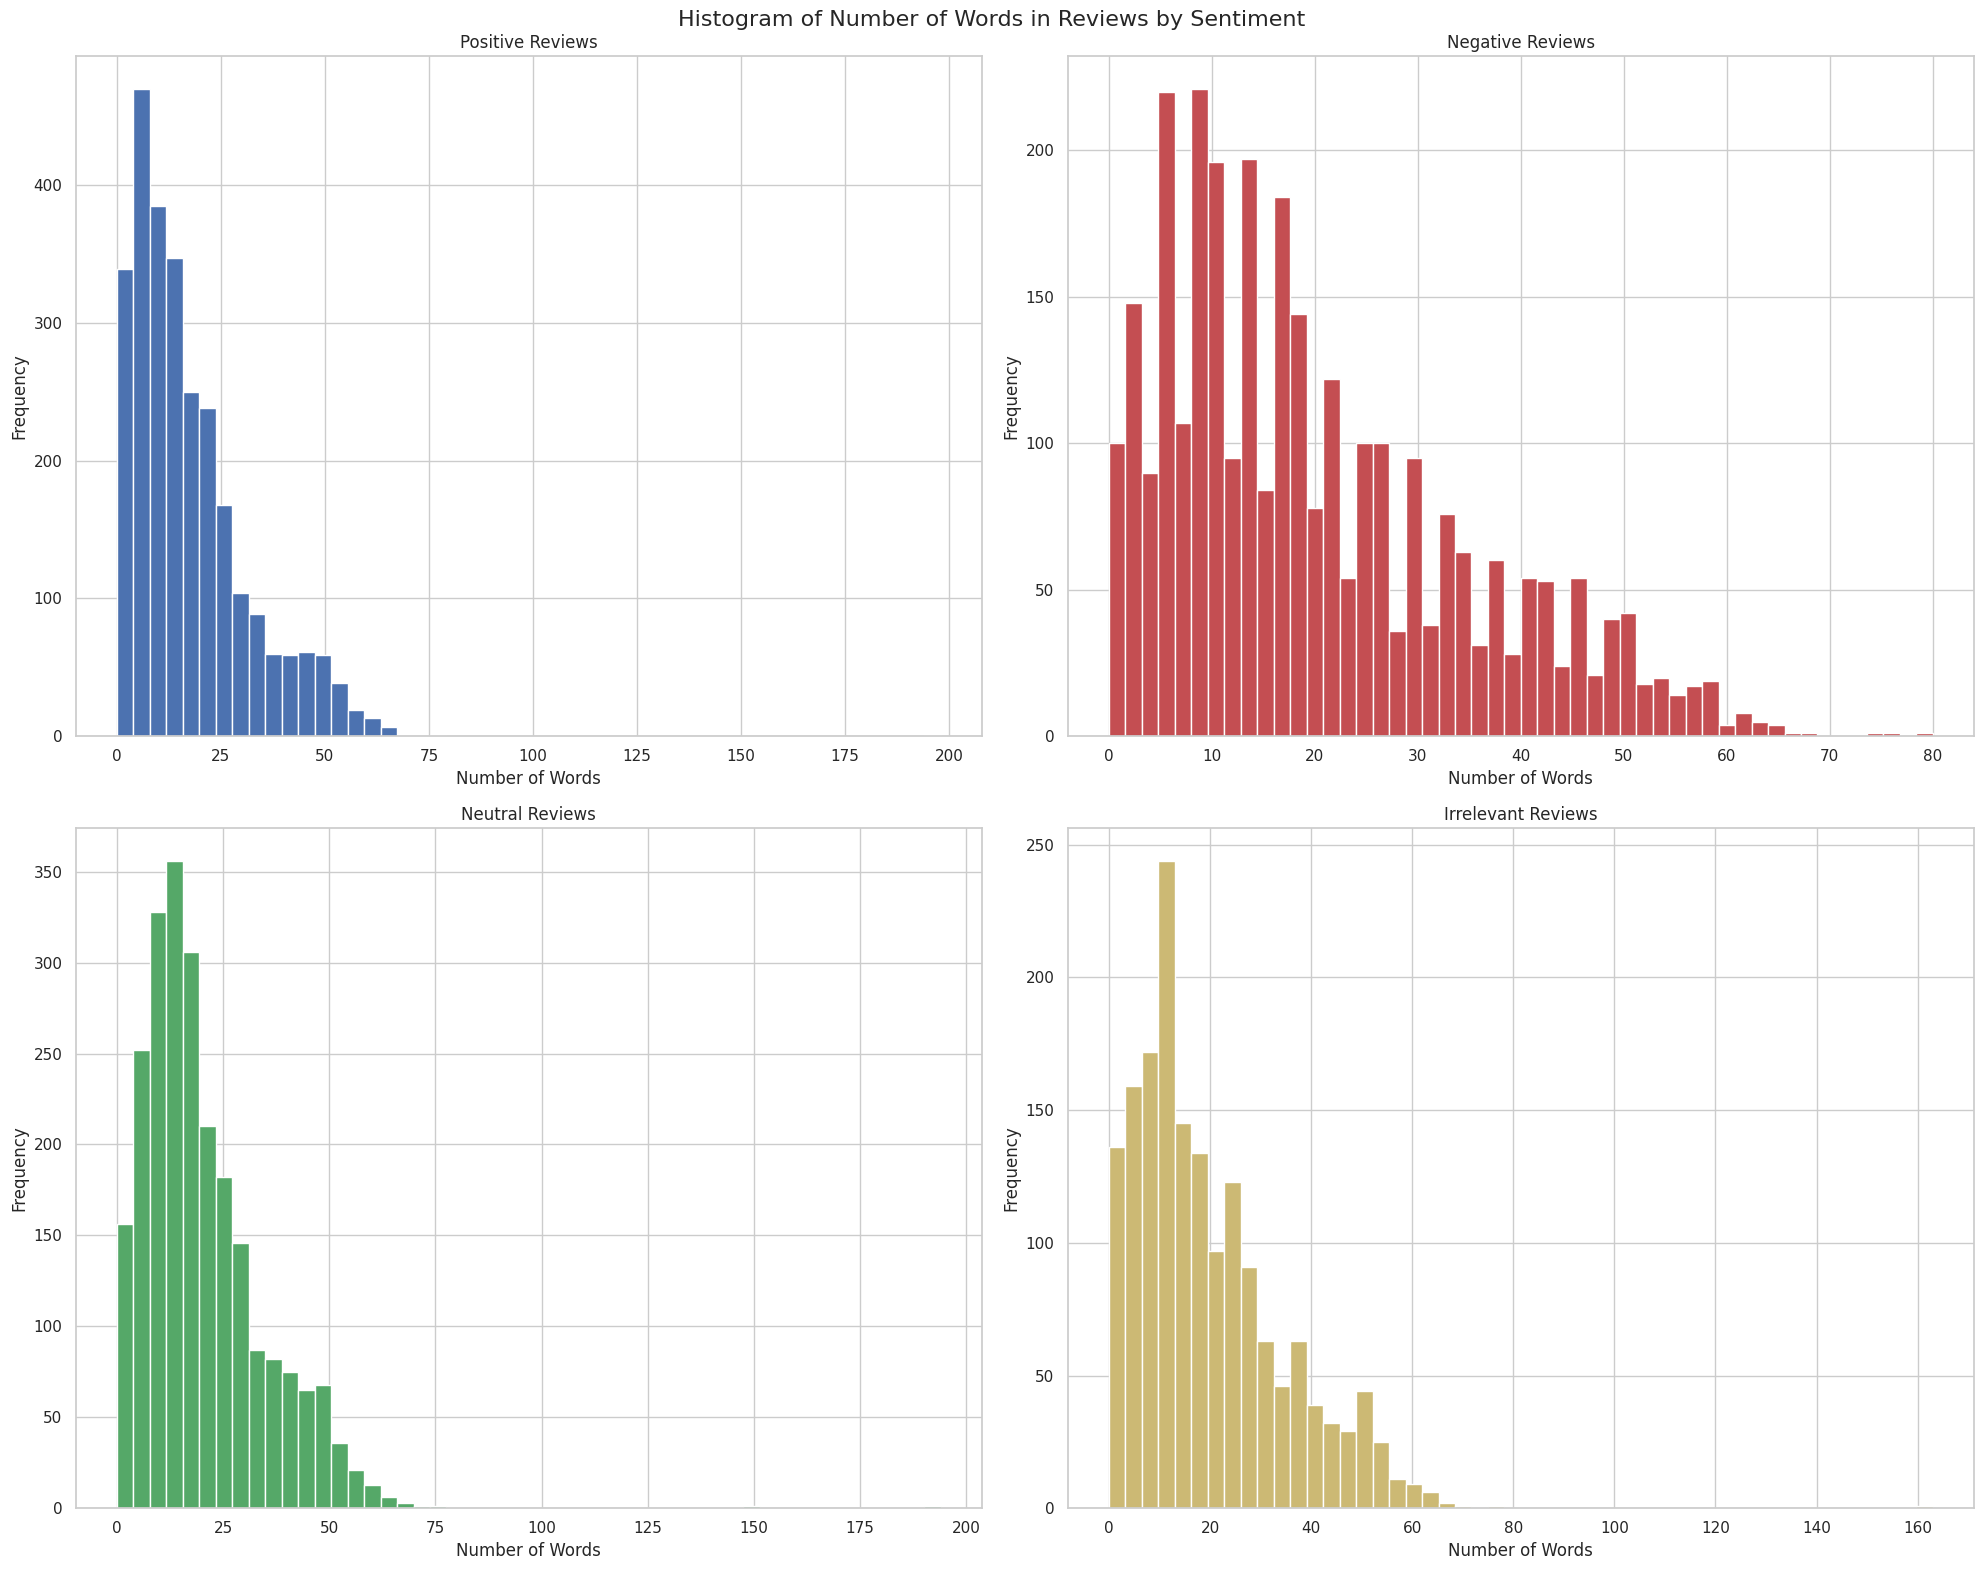

In [16]:
import matplotlib.pyplot as plt

# Ensure the 'Sentiment' column is of type string
train['Sentiment'] = train['Sentiment'].astype('string')

# Create a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Positive Reviews
ax1.hist(train[train['Sentiment'] == 'Positive']['Tweet Content'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')

# Negative Reviews
ax2.hist(train[train['Sentiment'] == 'Negative']['Tweet Content'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')

# Neutral Reviews
ax3.hist(train[train['Sentiment'] == 'Neutral']['Tweet Content'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')
ax3.set_xlabel('Number of Words')
ax3.set_ylabel('Frequency')

# Irrelevant Reviews
ax4.hist(train[train['Sentiment'] == 'Irrelevant']['Tweet Content'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Irrelevant Reviews')
ax4.set_xlabel('Number of Words')
ax4.set_ylabel('Frequency')

# Add a main title to the entire figure
fig.suptitle('Histogram of Number of Words in Reviews by Sentiment', fontsize=16)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


# List of methods commonly used for small text classification:

## Traditional Machine Learning Methods:
- **Support Vector Machines (SVM)**
- **Naive Bayes classifiers**
- **Logistic Regression**
- **Decision Trees**
- **Random Forests**
- **Gradient Boosting Machines (XGBoost)**
- **Gradient Boosting Machines (LightGBM)**

# Model Building

In [17]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [18]:
import pandas as pd
import plotly.graph_objects as go

# Assuming you've already run the data preprocessing steps
data = train[['Tweet Content', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Use the entire training data as data_train
data_train = data

# Use validation data as data_test
data_test = validation[['Tweet Content', 'Sentiment']]
data_test['Sentiment_label'] = pd.Categorical(data_test['Sentiment'])
data_test['Sentiment'] = data_test['Sentiment_label'].cat.codes

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_train.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_train[k].tolist()[:10] for k in data_train.columns],
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
              else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_train['Sentiment_label'][:10]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 10 Rows of Training Data',
    width=1000,
    height=600,
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Create a colorful table using Plotly for the test data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    
    cells=dict(
        values=[data_test[k].tolist()[:5] for k in data_test.columns],  # Show first 5 rows
        fill_color=[
            'lightcyan',  # Tweet Content
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment
            ['lightgreen' if s == 'Positive' else 'lightpink' if s == 'Negative'
             else 'lightyellow' if s == 'Neutral' else 'lightgray' for s in data_test['Sentiment_label'][:5]],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='First 5 Rows of Test Data',
    width=1000,
    height=600,
)

# Show the figure
fig.show()

# If you want to save the figure as an HTML file, uncomment the following line:
# fig.write_html("test_data_sample.html")

# SVM

**Support Vector Machines (SVM)** are powerful machine learning algorithms that excel in text classification tasks. They're particularly effective in distinguishing between different text categories, making them valuable for applications like sentiment analysis, topic labeling, and spam detection.

## How SVM Works for Text Classification

**Text Preprocessing:**

- Text data is cleaned and transformed into a numerical representation. This involves steps like tokenization, stop word removal, stemming, and lemmatization.
- Feature extraction techniques like TF-IDF (Term Frequency-Inverse Document Frequency) are employed to convert text into numerical vectors.

**Hyperplane Creation:**

- SVM aims to find the optimal hyperplane, which is a decision boundary that separates different text classes in the feature space.
- Each text document is represented as a point in this high-dimensional space based on its extracted features.

**Maximizing Margin:**

- SVM seeks the hyperplane that maximizes the margin between the different classes. This margin is the distance between the hyperplane and the closest data points from each class (support vectors).

**Classification:**

- New text documents are mapped to the same feature space.
- Their position relative to the hyperplane determines the predicted class.

**Key Concepts**

- Support Vectors: These are the data points closest to the hyperplane and significantly influence the model's decision boundary.
- Kernel Trick: SVM can handle non-linear relationships between features using the kernel trick, which implicitly maps data to a higher-dimensional space.
- Regularization: SVM uses regularization to prevent overfitting and improve generalization performance.

**Advantages of SVM for Text Classification**

Effective with high-dimensional data: Text data often has a large number of features. SVM handles such data efficiently.
Strong generalization performance: SVM tends to perform well on unseen data.
Handles complex patterns: The kernel trick allows SVM to capture complex relationships between words.

**Challenges and Considerations**

- Computational cost: SVM can be computationally expensive for large datasets.
- Parameter tuning: Choosing the right kernel and hyperparameters requires careful experimentation.
- Feature engineering: Effective feature extraction is crucial for SVM performance.

**In Conclusion**

SVM is a robust algorithm for text classification, offering excellent performance and versatility. By understanding its core principles and effectively addressing its challenges, you can leverage SVM to build accurate and reliable text classification models.

<center> <img src="https://www.researchgate.net/publication/344611577/figure/fig5/AS:945808459436032@1602509717117/Classification-scheme-of-SVM-method-a-two-class-classification-by-SVM-and-b-multi-class.png" width="1000" height="250"> </center>

<center> <img src="https://miro.medium.com/v2/resize:fit:863/1*ip8s18tMkZzM0pzsGuUN0Q.png" width="1200" height="300"> </center>

In [20]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Train the SVM model
Svm = SVC(kernel="linear")
Svm.fit(train_features, train_labels)

# Make predictions on the validation/test set
predictions = Svm.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
# Print accuracy
print("Test Accuracy SVM:", accuracy)
print("\n")

Test Accuracy SVM: 0.706


CPU times: user 16 s, sys: 199 ms, total: 16.2 s
Wall time: 16.2 s


In [21]:
# Print classification report

print("Classification Report SVM:\n")
print(classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"]))

Classification Report SVM:

              precision    recall  f1-score   support

    Negative       0.69      0.81      0.75       266
     Neutral       0.74      0.67      0.70       285
    Positive       0.70      0.78      0.74       277
  Irrelevant       0.69      0.48      0.57       172

    accuracy                           0.71      1000
   macro avg       0.71      0.69      0.69      1000
weighted avg       0.71      0.71      0.70      1000



In [22]:
# Print classification report

print("Classification Report SVM:\n")
SVM = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(SVM)

Classification Report SVM:

              precision    recall  f1-score   support

    Negative       0.69      0.81      0.75       266
     Neutral       0.74      0.67      0.70       285
    Positive       0.70      0.78      0.74       277
  Irrelevant       0.69      0.48      0.57       172

    accuracy                           0.71      1000
   macro avg       0.71      0.69      0.69      1000
weighted avg       0.71      0.71      0.70      1000



In [23]:
# Print confusion matrix
confusion_matrix_svm = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion_matrix_svm)

Confusion Matrix:
 [[216  22  19   9]
 [ 44 190  35  16]
 [ 24  24 217  12]
 [ 29  20  40  83]]


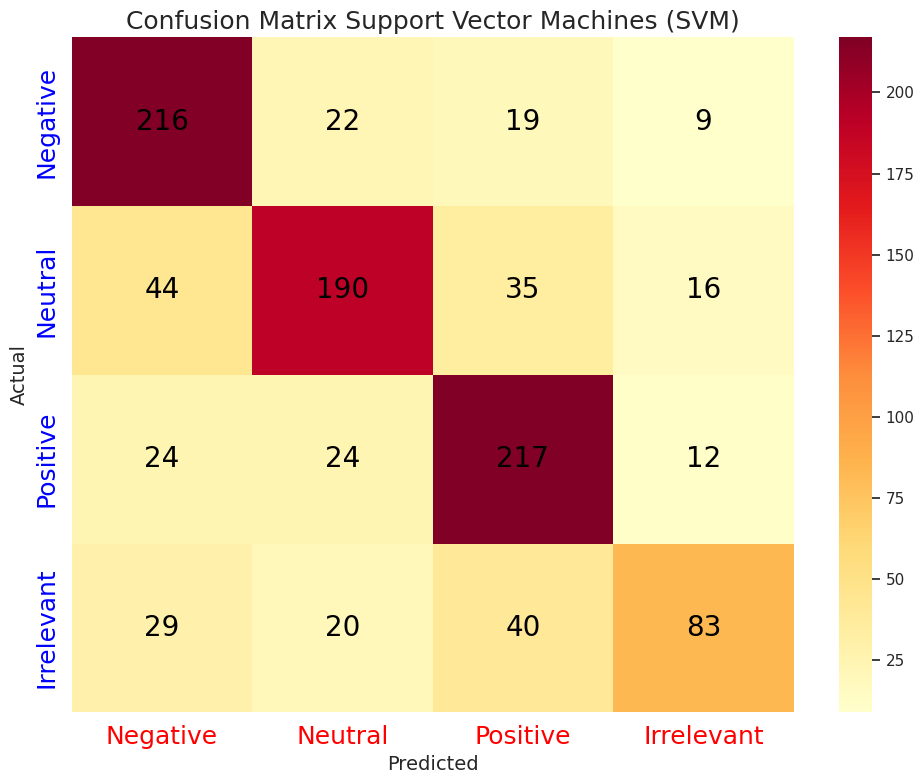

In [24]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_svm, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix Support Vector Machines (SVM)', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

# Naive Bayes classifiers

**Naive Bayes** is a probabilistic classification algorithm based on Bayes' theorem, particularly suited for text classification tasks. It's a simple yet effective method for categorizing text into different classes.

**How it works:**

- **Text Preprocessing:** Similar to other text classification methods, the text data undergoes preprocessing steps like tokenization, stop word removal, and stemming or lemmatization.
- **Feature Extraction:** Words or n-grams (sequences of words) are typically used as features. These features are converted into numerical representations, often using techniques like TF-IDF.
- **Probability Calculation:** Naive Bayes calculates the probability of a document belonging to a particular class based on the presence of specific words or features.
- **Bayes' Theorem Application:** The algorithm applies Bayes' theorem to calculate the posterior probability of a class given the document's features.
- **Classification:** The class with the highest probability is assigned to the document.

**Key Assumption:**

- The Naive Bayes algorithm makes a simplifying assumption: the occurrence of one word in a document is independent of the occurrence of other words. While this assumption is often not strictly true in natural language, it works surprisingly well in practice.

**Advantages of Naive Bayes for Text Classification:**

- **Simplicity:** Easy to understand and implement.
- **Efficiency:** Fast training and prediction times.
- **Effective with high-dimensional data:** Handles text data with large vocabularies well.
- **Works well with small datasets:** Can achieve reasonable performance with limited training data.

**Common Use Cases:**

- **Spam filtering:** Classifying emails as spam or non-spam.
- **Sentiment analysis:** Determining the sentiment of text (positive, negative, neutral).
- **Topic modeling:** Assigning documents to predefined topics.
- **Author identification:** Identifying the author of a text.

**Challenges:**

- **Naive Bayes assumption:** The independence assumption might not hold true in all cases, affecting accuracy.
- **Zero-frequency problem:** If a word doesn't appear in a training set for a particular class, its probability becomes zero, impacting calculations. This can be addressed using techniques like Laplace smoothing.

**In Summary:**

Naive Bayes is a popular and efficient algorithm for text classification due to its simplicity and ability to handle high-dimensional data. While it makes a simplifying assumption about feature independence, it often performs well in practice. It's a good starting point for many text classification tasks.

<center> <img src="https://www.researchgate.net/publication/372647720/figure/fig1/AS:11431281181502340@1692037770182/Text-classification-using-Naive-Bayes.png" width="1000" height="250"> </center>

<center> <img src="https://www.norwegiancreations.com/wp-content/uploads/2018/10/Bayes_Rule-1.png" width="600" height="200"> </center>

In [25]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Train the Naive Bayes model
NB = MultinomialNB()
NB.fit(train_features, train_labels)

# Make predictions on the validation/test set
predictions = NB.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
# Print accuracy
print("Test Accuracy Naive Bayes:", accuracy)
print("\n")

Test Accuracy Naive Bayes: 0.626


CPU times: user 303 ms, sys: 1.9 ms, total: 305 ms
Wall time: 307 ms


In [26]:
# Print classification report

print("Classification Report Naive Bayes:\n")
NB = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(NB)

Classification Report Naive Bayes:

              precision    recall  f1-score   support

    Negative       0.56      0.84      0.67       266
     Neutral       0.72      0.55      0.62       285
    Positive       0.62      0.78      0.69       277
  Irrelevant       0.85      0.17      0.28       172

    accuracy                           0.63      1000
   macro avg       0.69      0.59      0.57      1000
weighted avg       0.67      0.63      0.60      1000



In [27]:
# Print confusion matrix
confusion_matrix_NB = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion_matrix_NB)

Confusion Matrix:
 [[224  18  23   1]
 [ 77 156  50   2]
 [ 39  19 217   2]
 [ 59  23  61  29]]


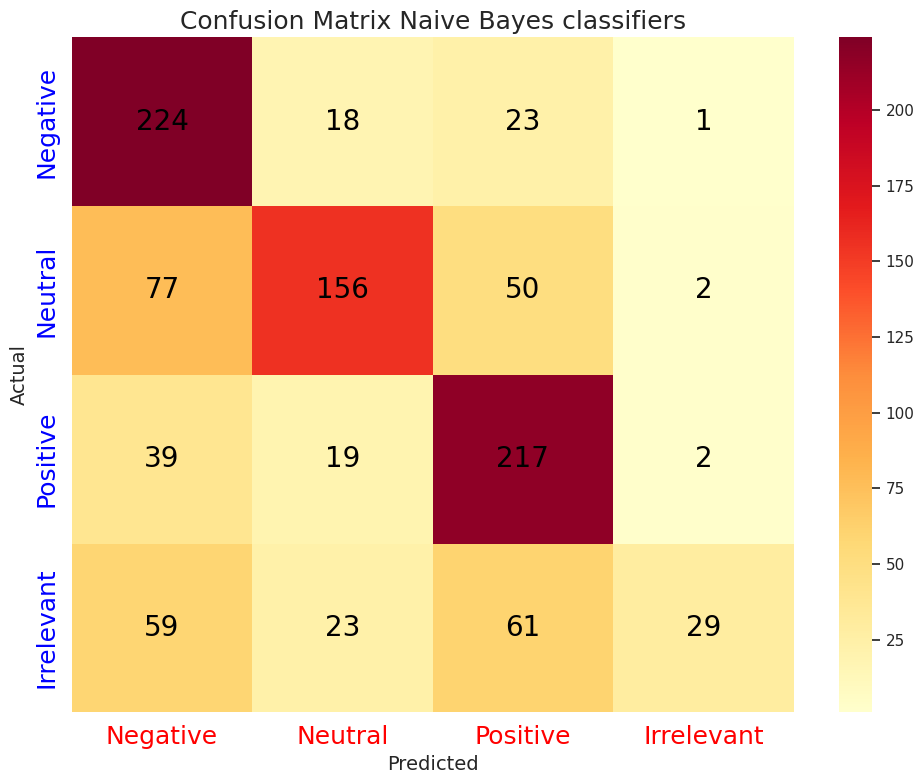

In [28]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_NB, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix Naive Bayes classifiers', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

# Logistic Regression

**Logistic Regression is a statistical method for predicting the probability of a binary outcome. While it's primarily designed for binary classification, it can be extended to multi-class classification problems as well.**

**How it works for Text Classification:**

- **Text Preprocessing:** Similar to other text classification methods, the text data is cleaned and transformed into numerical features. This involves tokenization, stop word removal, stemming, and lemmatization.
- **Feature Extraction:** Text is converted into numerical features using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or word embeddings.
- **Model Training:** The Logistic Regression model is trained on the numerical representation of the text data and corresponding class labels. The model learns the relationship between the features and the target class.
- **Probability Estimation:** For a new text document, the model calculates the probability of the document belonging to each class.
- **Classification:** The class with the highest probability is assigned to the document.

**Key Points:**

- **Probability Estimation:** Unlike some other classification algorithms, Logistic Regression provides probability estimates for each class, which can be useful in certain applications.
- **Multi-class Classification:** For problems with more than two classes, techniques like one-vs-rest or multinomial logistic regression can be used.
- **Interpretability:** The coefficients of the Logistic Regression model can provide insights into the importance of different features in the classification process.

**Advantages:**

- **Simplicity:** Relatively easy to understand and implement.
- **Efficiency:** Can be computationally efficient, especially for smaller datasets.
- **Probabilistic Output:** Provides probability estimates for each class, which can be valuable in certain applications.

**Challenges:**

- **Feature Engineering:** Effective feature extraction is crucial for model performance.
- **Overfitting:** Can be prone to overfitting if not regularized properly.

**Applications:**

- Sentiment analysis
- Spam detection
- Topic classification
- Customer review categorization

In essence, Logistic Regression offers a balance of simplicity, interpretability, and performance for text classification tasks. While it may not always outperform more complex models, it's often a good starting point and can provide valuable insights into the data.

In [29]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)


# Train the Logistic Regression model
Lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')  # Multiclass with L-BFGS solver

# Fit the model
Lr.fit(train_features, train_labels)

# Make predictions on the validation/test set
predictions = Lr.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Print accuracy
print("Test Accuracy Logistic Regression:", accuracy)
print("\n")

Test Accuracy Logistic Regression: 0.692


CPU times: user 3.86 s, sys: 3.95 s, total: 7.82 s
Wall time: 2.9 s


In [30]:
# Print classification report

print("Classification Report Logistic Regression:\n")
LR = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(LR)

Classification Report Logistic Regression:

              precision    recall  f1-score   support

    Negative       0.67      0.79      0.73       266
     Neutral       0.72      0.66      0.69       285
    Positive       0.68      0.78      0.73       277
  Irrelevant       0.72      0.44      0.55       172

    accuracy                           0.69      1000
   macro avg       0.70      0.67      0.67      1000
weighted avg       0.70      0.69      0.69      1000



In [31]:
# Print confusion matrix
confusion_matrix_lr = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n\n", confusion_matrix_lr)

Confusion Matrix:

 [[211  23  24   8]
 [ 49 189  35  12]
 [ 22  29 216  10]
 [ 32  22  42  76]]


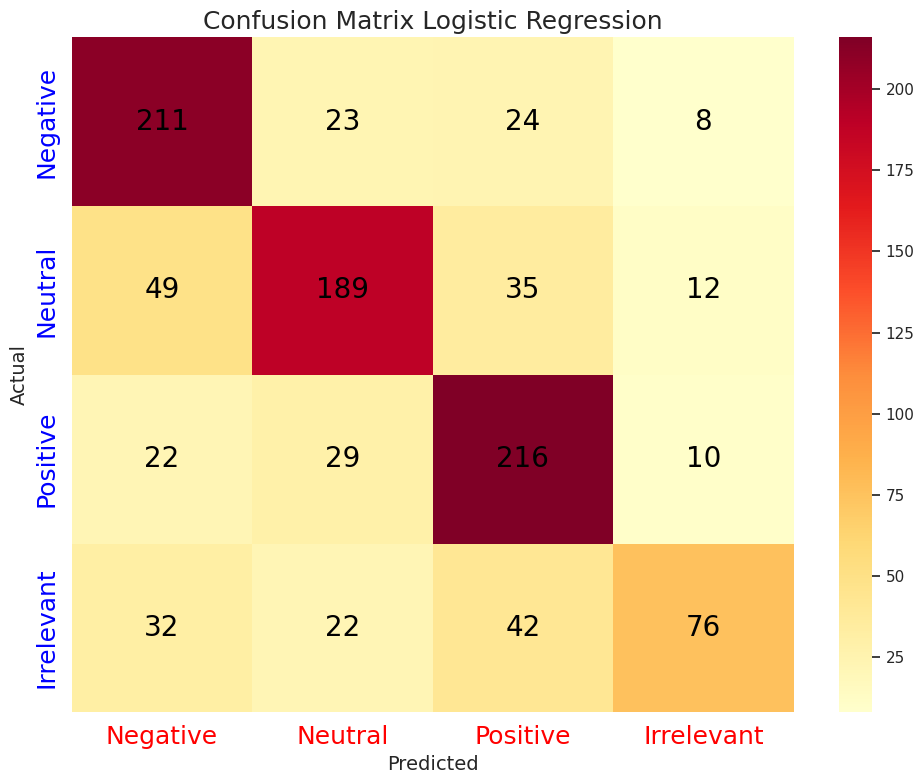

In [32]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_lr, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix Logistic Regression', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

# Decision Trees

In [33]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Train the Decision Tree Classifier model
Dt = DecisionTreeClassifier(random_state=42)  # Set random state for reproducibility

# Fit the model
Dt.fit(train_features, train_labels)

# Make predictions on the validation/test set
predictions = Dt.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
# Print accuracy
print("Test Accuracy Decision Tree:", accuracy)
print("\n")

Test Accuracy Decision Tree: 0.605


CPU times: user 2.28 s, sys: 6.46 ms, total: 2.29 s
Wall time: 2.32 s


In [34]:
# Print classification report

print("Classification Report Decision Trees:\n")
Dt = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(Dt)

Classification Report Decision Trees:

              precision    recall  f1-score   support

    Negative       0.63      0.64      0.63       266
     Neutral       0.65      0.60      0.62       285
    Positive       0.58      0.65      0.61       277
  Irrelevant       0.54      0.49      0.51       172

    accuracy                           0.60      1000
   macro avg       0.60      0.59      0.60      1000
weighted avg       0.61      0.60      0.60      1000



In [35]:
# Print confusion matrix
confusion_matrix_dt = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n\n", confusion_matrix_dt)

Confusion Matrix:

 [[170  29  42  25]
 [ 38 170  55  22]
 [ 35  36 181  25]
 [ 27  26  35  84]]


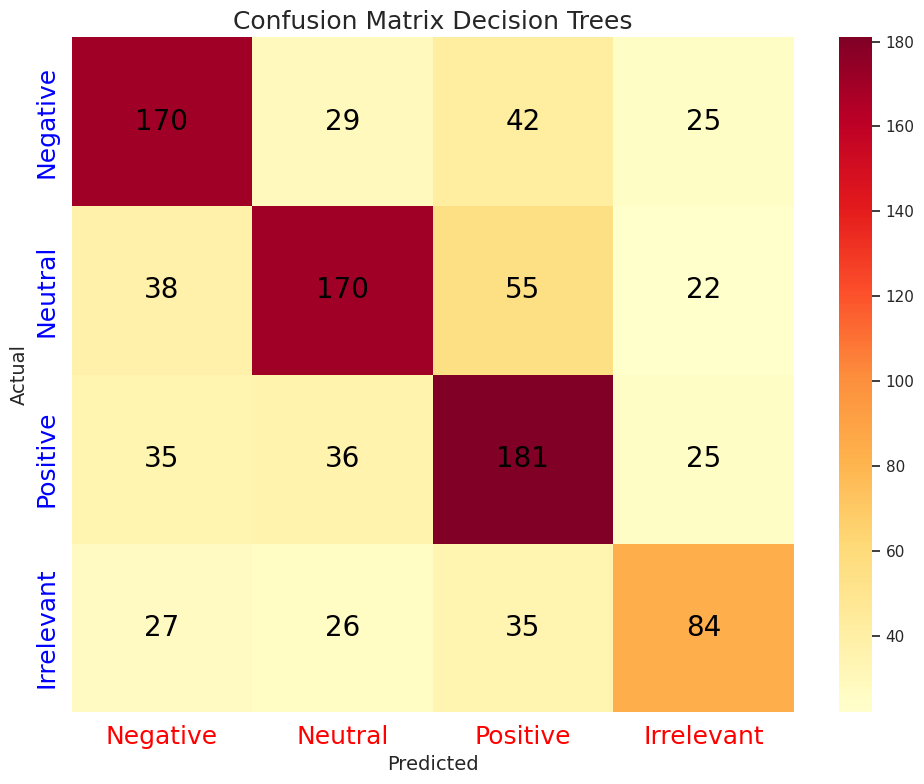

In [36]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_dt, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix Decision Trees', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

# Random Forests

In [37]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Train the Random Forest Classifier model
Rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed

# Fit the model
Rf.fit(train_features, train_labels)

# Make predictions on the validation/test set
predictions = Rf.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
# Print accuracy
print("Test Accuracy Random Forest:", accuracy)
print("\n")

Test Accuracy Random Forest: 0.73


CPU times: user 13.8 s, sys: 38.2 ms, total: 13.9 s
Wall time: 13.9 s


In [38]:
# Print classification report

print("Classification Report Random Forests:\n")
Rf = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(Rf)

Classification Report Random Forests:

              precision    recall  f1-score   support

    Negative       0.69      0.85      0.76       266
     Neutral       0.76      0.73      0.75       285
    Positive       0.71      0.80      0.75       277
  Irrelevant       0.88      0.42      0.57       172

    accuracy                           0.73      1000
   macro avg       0.76      0.70      0.71      1000
weighted avg       0.75      0.73      0.72      1000



In [39]:
# Print confusion matrix
confusion_matrix_rf = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n\n", confusion_matrix_rf)

Confusion Matrix:

 [[227  13  21   5]
 [ 45 209  31   0]
 [ 28  23 221   5]
 [ 31  30  38  73]]


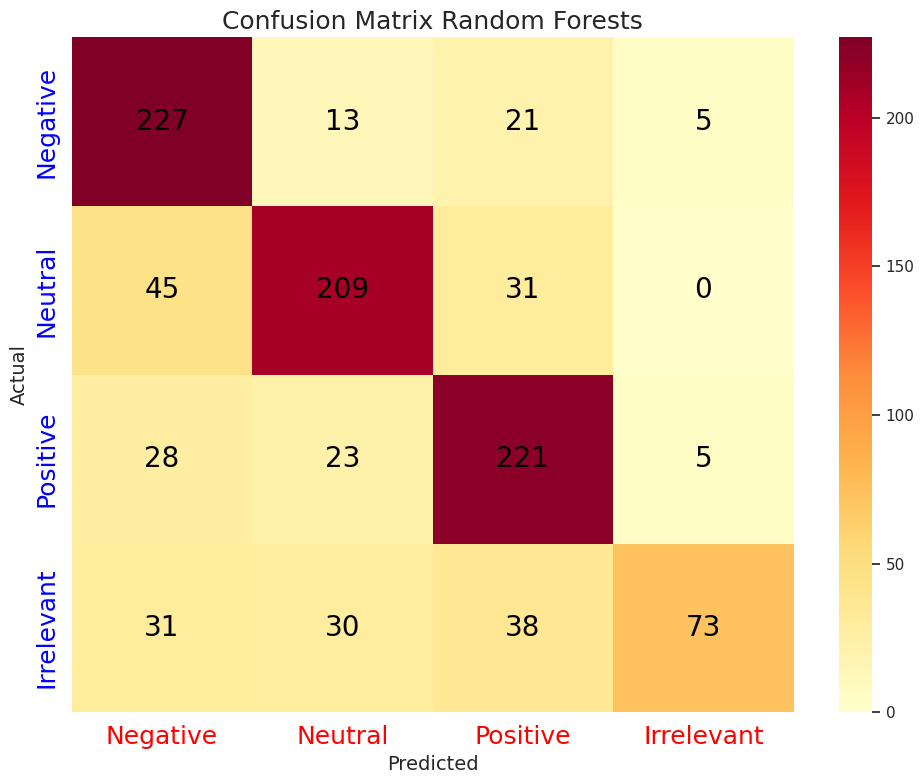

In [40]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix Random Forests', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

# Gradient Boosting Machines (XGBoost)

In [41]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
train_labels = data_train["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})
test_texts = data_test["Tweet Content"].tolist()
test_labels = data_test["Sentiment_label"].map({"Positive": 2, "Negative": 0, "Neutral": 1, "Irrelevant": 3})

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': 4,  # Number of classes
    'eta': 0.3,  # Learning rate
    'max_depth': 6,  # Maximum depth of trees
    'eval_metric': 'mlogloss'  # Evaluation metric
}

# Train the XGBoost model
Xgb = xgb.train(params, dtrain, num_boost_round=10)  # Adjust num_boost_round as needed

# Make predictions on the validation/test set
predictions = Xgb.predict(dtest)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
# Print accuracy
print("Test Accuracy XGBoost:", accuracy)
print("\n")

Test Accuracy XGBoost: 0.515


CPU times: user 8.31 s, sys: 89.3 ms, total: 8.4 s
Wall time: 2.53 s


In [42]:
# Print classification report

print("Classification Report XGBoost:\n")
Xgb = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(Xgb)

Classification Report XGBoost:

              precision    recall  f1-score   support

    Negative       0.43      0.76      0.55       266
     Neutral       0.62      0.47      0.53       285
    Positive       0.56      0.53      0.55       277
  Irrelevant       0.66      0.18      0.28       172

    accuracy                           0.52      1000
   macro avg       0.57      0.49      0.48      1000
weighted avg       0.56      0.52      0.50      1000



In [43]:
# Print confusion matrix
confusion_matrix_xgb = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n\n", confusion_matrix_xgb)

Confusion Matrix:

 [[203  25  27  11]
 [103 133  47   2]
 [ 93  33 148   3]
 [ 76  24  41  31]]


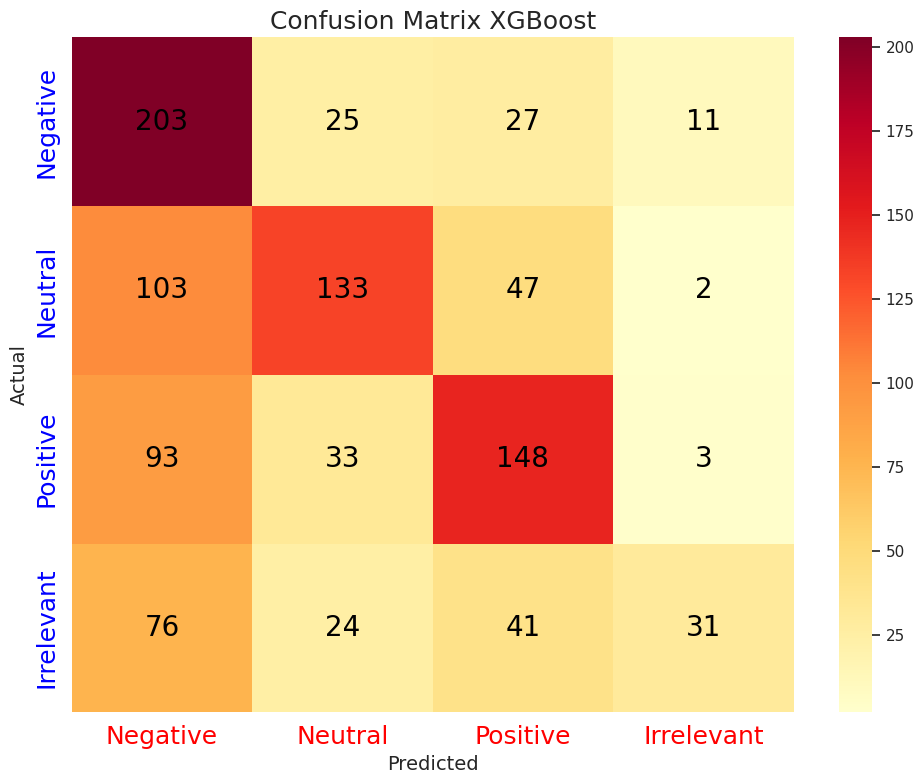

In [44]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix XGBoost', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

 # Gradient Boosting Machines (LightGBM)

In [45]:
%%time

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Extract text and labels
train_texts = data_train["Tweet Content"].tolist()
test_texts = data_test["Tweet Content"].tolist()

# Use LabelEncoder to convert categorical labels to numerical
le = LabelEncoder()
train_labels = le.fit_transform(data_train["Sentiment_label"])
test_labels = le.transform(data_test["Sentiment_label"])

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

# Create LightGBM datasets
train_data = lgb.Dataset(train_features, label=train_labels)
test_data = lgb.Dataset(test_features, label=test_labels)

# Set LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'max_depth': -1,
    'num_leaves': 31
}

# Train the LightGBM model
Lgbm = lgb.train(
    params, 
    train_data, 
    valid_sets=[test_data], 
    num_boost_round=100,
    callbacks=[lgb.log_evaluation(period=100)]
)

# Make predictions on the validation/test set
predictions = Lgbm.predict(test_features)
predictions = predictions.argmax(axis=1)  # Convert probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print("\n")
# Print accuracy
print("\033[91mTest Accuracy LightGBM:\033[0m", accuracy)
print("\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35030
[LightGBM] [Info] Number of data points in the train set: 9847, number of used features: 1025
[LightGBM] [Info] Start training from score -1.772548
[LightGBM] [Info] Start training from score -1.165815
[LightGBM] [Info] Start training from score -1.413366
[LightGBM] [Info] Start training from score -1.290587
[100]	valid_0's multi_logloss: 0.86044


Test Accuracy LightGBM: 0.672


CPU times: user 21.8 s, sys: 296 ms, total: 22.1 s
Wall time: 8.66 s


In [46]:
# Print classification report

print("Classification Report LightGBM:\n")
Lgbm = classification_report(test_labels, predictions, target_names=["Negative", "Neutral", "Positive", "Irrelevant"])
print(Lgbm)

Classification Report LightGBM:

              precision    recall  f1-score   support

    Negative       0.66      0.47      0.55       172
     Neutral       0.64      0.76      0.70       266
    Positive       0.70      0.66      0.68       285
  Irrelevant       0.68      0.72      0.70       277

    accuracy                           0.67      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       0.67      0.67      0.67      1000



In [47]:
# Print confusion matrix
confusion_matrix_lgbm = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n\n", confusion_matrix_lgbm)

Confusion Matrix:

 [[ 81  34  19  38]
 [ 14 203  28  21]
 [ 14  49 188  34]
 [ 13  30  34 200]]


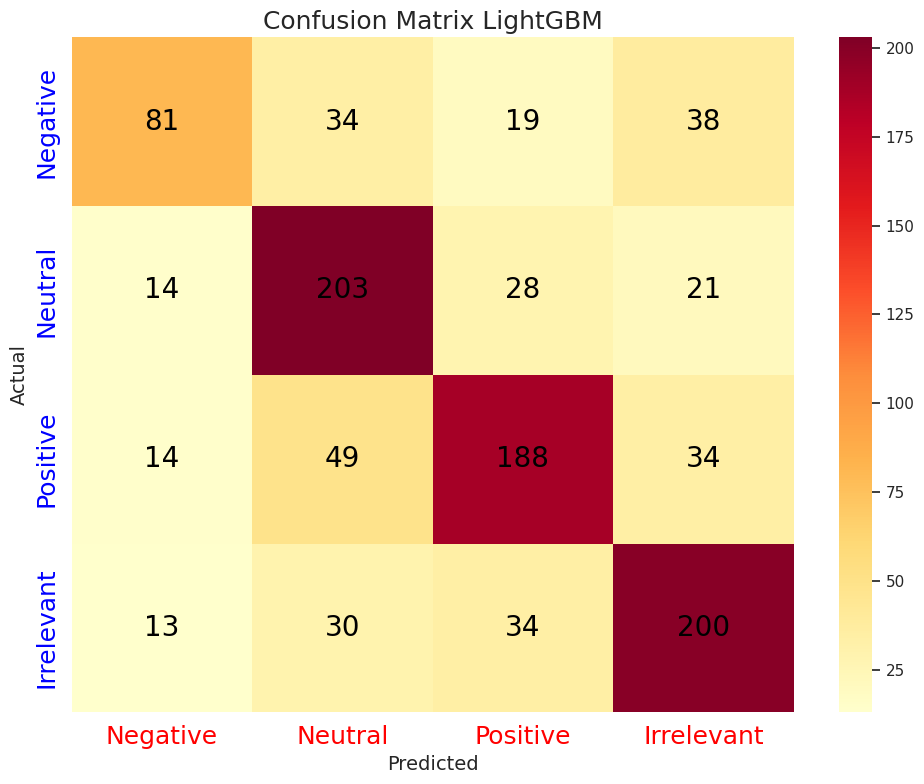

In [48]:
plt.figure(figsize=(10, 8))  # Increased figure size for better visibility
sns.heatmap(confusion_matrix_lgbm, annot=True, fmt='d', cmap='YlOrRd',annot_kws={"size": 20, "color": "Black"})  # Increased annotation size
plt.title('Confusion Matrix LightGBM', fontsize=18)  # Increased title size
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18,color = 'Red')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=18, color= 'Blue')
plt.tight_layout()
plt.show()

| Model  | Accuracy | 
|------------|	|
| Test Accuracy SVM: |  0.694 |
| Test Accuracy Naive Bayes: | 0.627 |
| Test Accuracy Logistic Regression: | 0.679 |
| Test Accuracy Decision Tree: |  0.601 |
| Test Accuracy Random Forest:| 0.731|
| Test Accuracy XGBoost:| 0.533 |
| Test Accuracy LightGBM:| 0.668 |

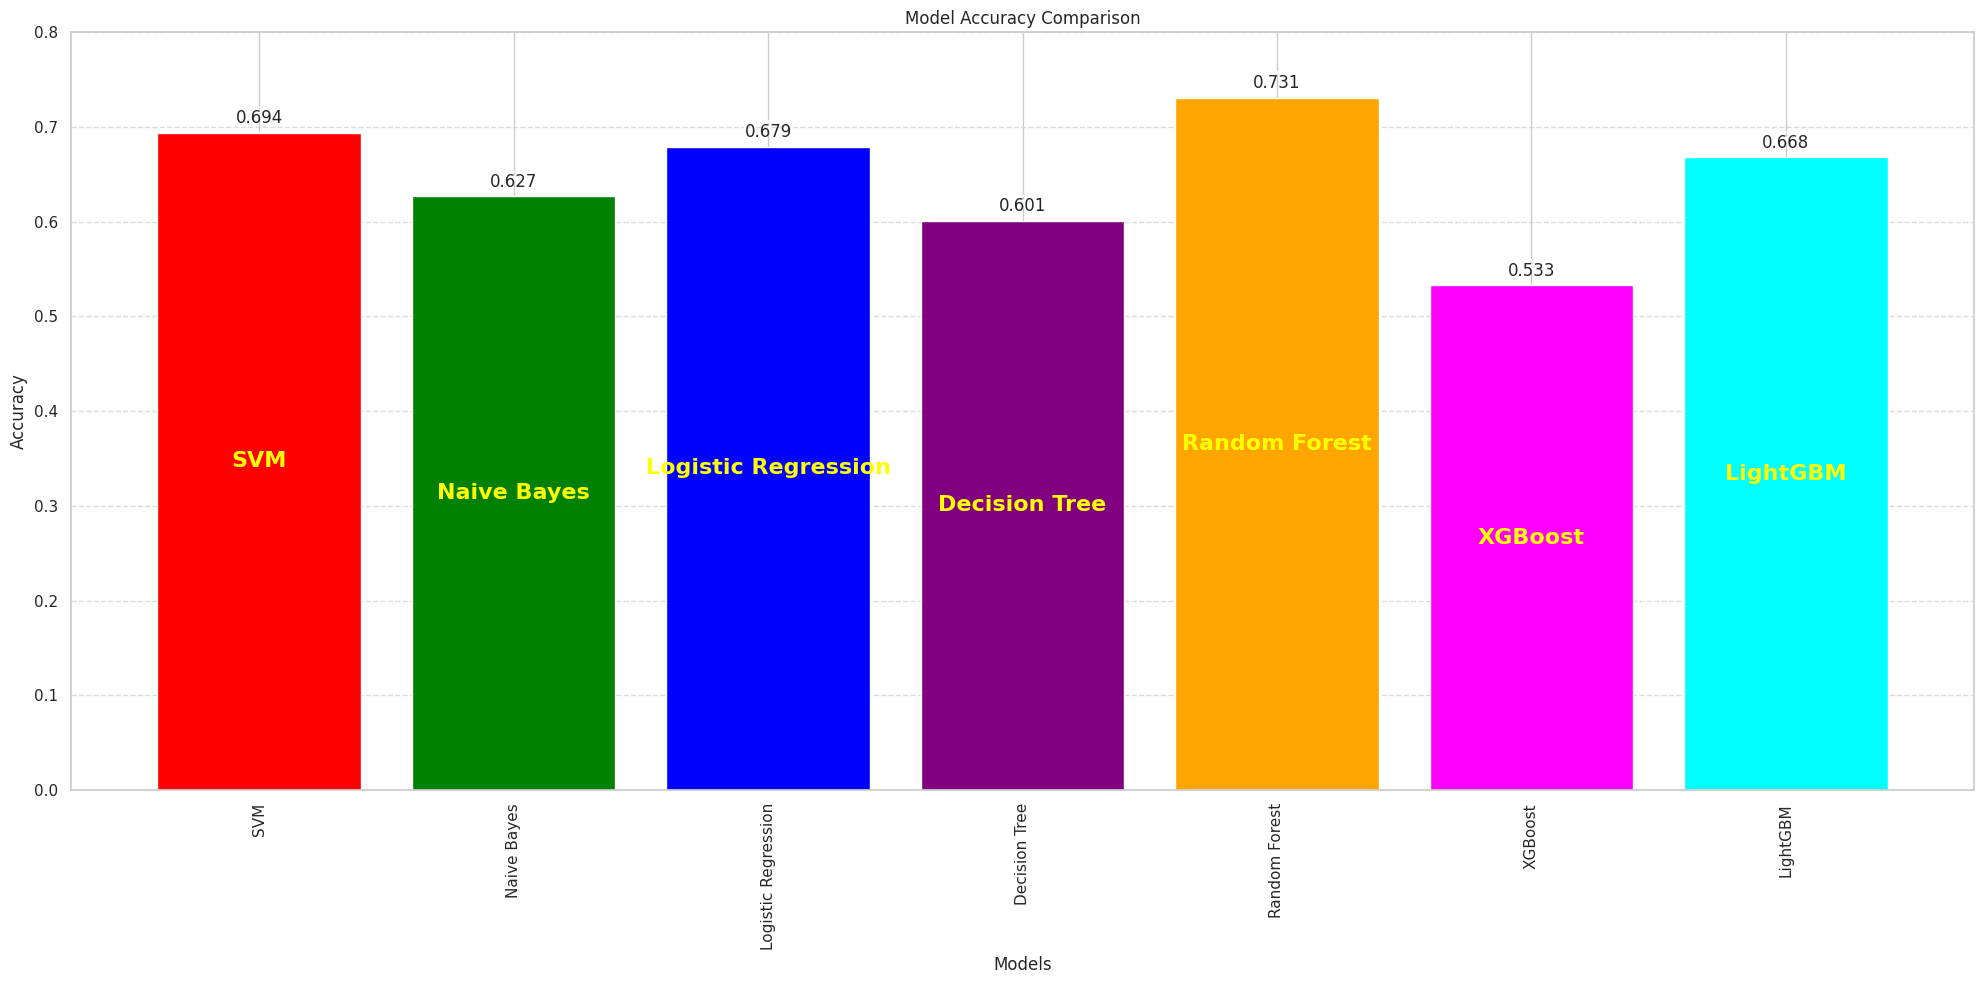

In [49]:
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 

# Model names and their corresponding accuracies
models = ['SVM', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
accuracies = [0.694, 0.627, 0.679, 	0.601, 0.731, 0.533, 0.668]

# Create a list of different colors for the bars
colors = ['red', 'green', 'blue', 'purple', 'orange', 'magenta', 'cyan']

# Create the bar graph
plt.bar(models, accuracies, color=colors)

# Add value labels on top of each bar with white color
for index, (value, model_name) in enumerate(zip(accuracies, models)):
    plt.text(index, value + 0.01, str(value), ha='center', va='bottom', color='white', fontsize=12,fontweight='bold')

    # Add model names within the bars with white color and adjust vertical alignment
    plt.text(index, value / 2, model_name, ha='center', va='center', color='Yellow', fontsize=16, fontweight='bold')  # Shorten model names for better fit
    
# Add value labels on top of each bar
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.01, str(value), ha='center')


plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.ylim([0, .8])
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a faint grid for better readability

plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()


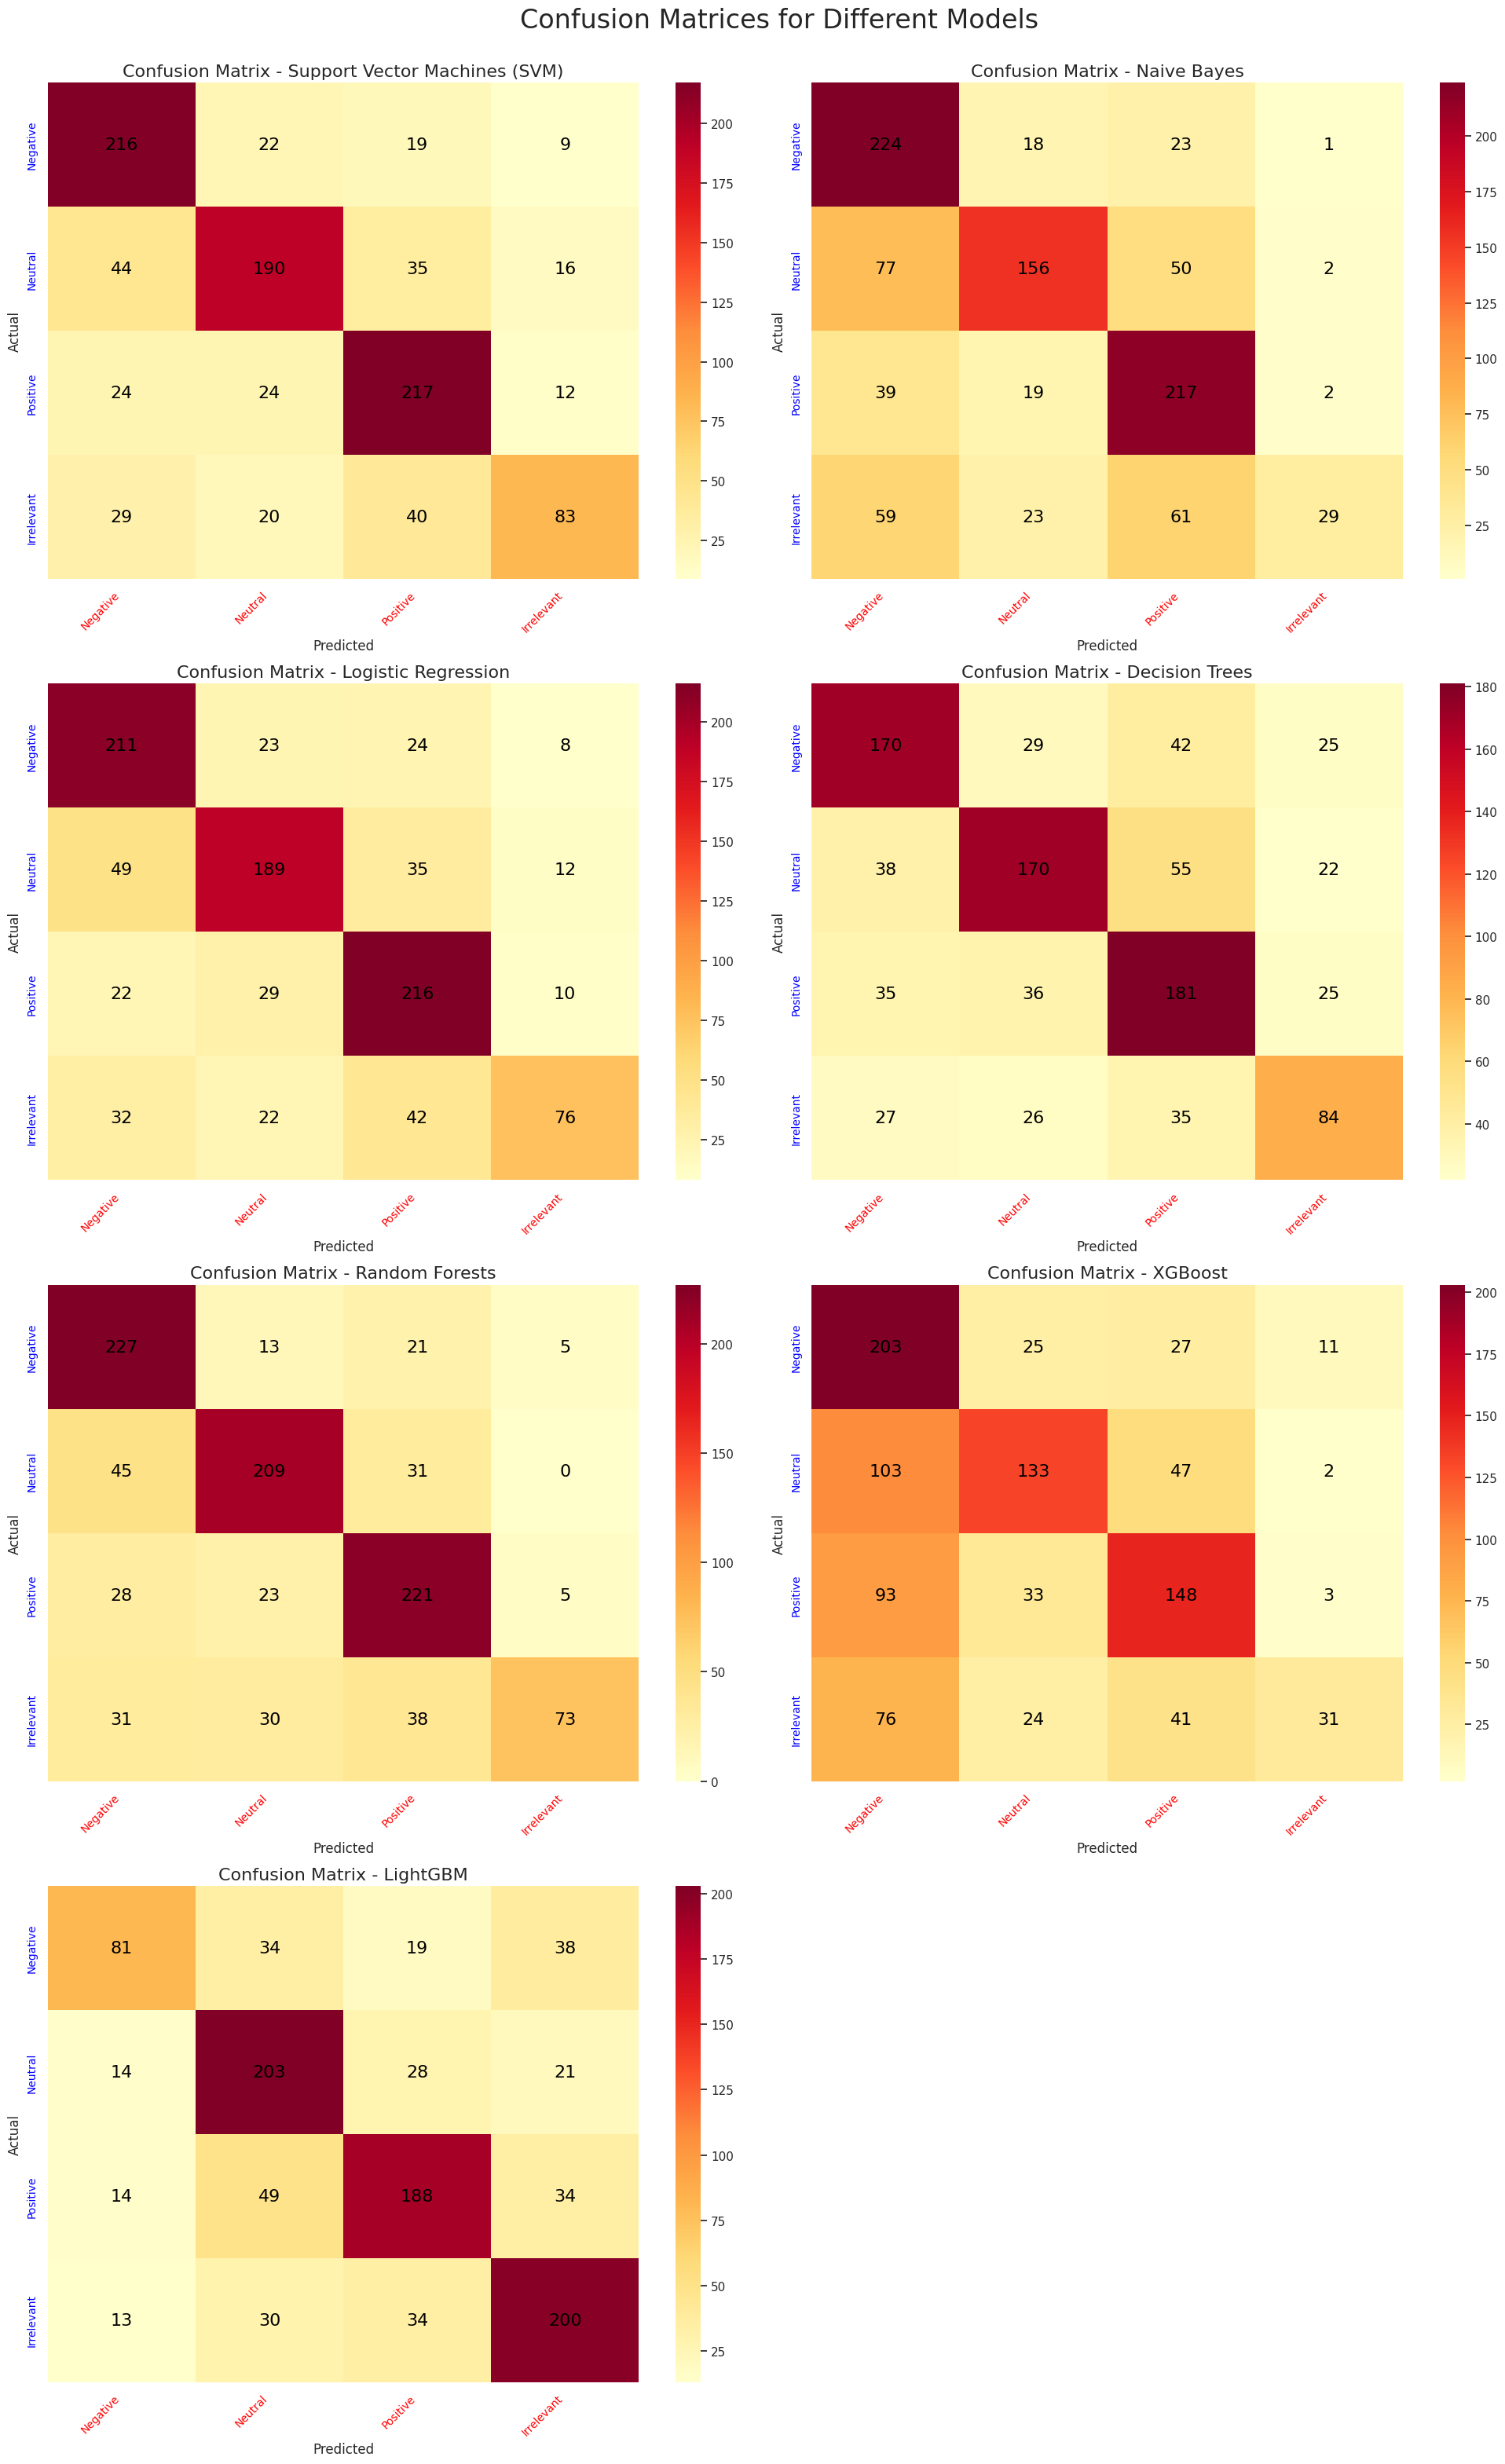

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 32))
fig.suptitle('Confusion Matrices for Different Models', fontsize=24)

# List of models and their corresponding confusion matrices
models = [
    ('Support Vector Machines (SVM)', confusion_matrix_svm),
    ('Naive Bayes', confusion_matrix_NB),
    ('Logistic Regression', confusion_matrix_lr),
    ('Decision Trees', confusion_matrix_dt),
    ('Random Forests', confusion_matrix_rf),
    ('XGBoost', confusion_matrix_xgb),
    ('LightGBM', confusion_matrix_lgbm)
]

# Plot each confusion matrix
for i, (title, matrix) in enumerate(models):
    ax = axes[i // 2, i % 2]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax, annot_kws={"size": 16, "color": "Black"})
    ax.set_title(f'Confusion Matrix - {title}', fontsize=16)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=10, color='Red', rotation=45, ha='right')
    ax.set_yticklabels(['Negative', 'Neutral', 'Positive', 'Irrelevant'], fontsize=10, color='Blue')

# Remove the last subplot if there's an odd number of models
if len(models) % 2 != 0:
    fig.delaxes(axes.flatten()[-1])

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust to make room for the main title
plt.show()